# Learning to stabilize nonlinear ODE

For this example we demonstrate learning to stabilize an underactuated nonlinear ODE system using [Differentiable predictive control (DPC) method](https://www.sciencedirect.com/science/article/pii/S0959152422000981). 

**Differentiable Predictive Control method**:  
The DPC is a model-based policy optimization algorithm, that exploits the differentiability of a wide class of model representations for dynamical systems, including differential equations, state-space models, or various neural network architectures. In DPC, we construct a differentiable closed-loop system composed of neural control policy and system dynamics model that is to be optimized using parametric control objectives as intrinsic reward signals evaluated over a sampled distribution of the problem parameters.

<img src="./figs/DPC_simple_method.png" width="600">  

system: [Van der Pol oscillator](https://en.wikipedia.org/wiki/Van_der_Pol_oscillator)  
see section V.A in for system equations: https://arxiv.org/abs/2203.14114  
objective: stabilize towards origin   


## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

In [1]:
!pip install "neuromancer[examples] @ git+https://github.com/pnnl/neuromancer.git@master"

  Cloning https://github.com/pnnl/neuromancer.git (to revision master) to c:\users\drgo694\appdata\local\temp\pip-install-grude3rc\neuromancer_a948fdde05f447218e6f26c764267870
  Resolved https://github.com/pnnl/neuromancer.git to commit 357f7ac5da1e653e9d6b2d2040328a262eaa19ae
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     --------------------------------------- 18.2/18.2 MB 34.5 MB/s eta 0:00:00
  Using cached colorama-0.4.5-py2.py3-none-any.whl (16 kB)
  Using cached pygame-2.5.1-cp310-cp310-win_amd64.whl (10.6 MB)
  Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)
  Using cached gymnasium-0.

  Running command git clone --filter=blob:none --quiet https://github.com/pnnl/neuromancer.git 'C:\Users\drgo694\AppData\Local\Temp\pip-install-grude3rc\neuromancer_a948fdde05f447218e6f26c764267870'


In [1]:
import torch
import torch.nn as nn
import numpy as np

import neuromancer.psl as psl
from neuromancer.system import Node, System
from neuromancer.modules import blocks
from neuromancer.modules.activations import activations
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
from neuromancer.dynamics import ode, integrators
from neuromancer.plot import pltCL, pltPhase

## Ground truth system model

In [2]:
gt_model = psl.nonautonomous.VanDerPolControl()
# sampling rate
ts = gt_model.params[1]['ts']
# problem dimensions
nx = gt_model.nx    # number of states
nu = gt_model.nu    # number of control inputs
nref = nx           # number of references
# constraints bounds
umin = -5.
umax = 5.
xmin = -4.
xmax = 4.

## Training dataset generation

For a training dataset we randomly sample points away from the origin of the 2D space the systemn operates in. 

In [3]:
nsteps = 50  # prediction horizon
n_samples = 2000    # number of sampled scenarios
# Training dataset generation
train_data = DictDataset({'x': torch.randn(n_samples, 1, nx),
                          'r': torch.zeros(n_samples, nsteps+1, nx)}, name='train')
# Development dataset generation
dev_data = DictDataset({'x': torch.randn(n_samples, 1, nx),
                        'r': torch.zeros(n_samples, nsteps+1, nx)}, name='dev')
# torch dataloaders
batch_size = 200
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           collate_fn=train_data.collate_fn, shuffle=False)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=batch_size,
                                         collate_fn=dev_data.collate_fn, shuffle=False)

## System model and Control policy in Neuromancer

In [4]:
# white-box ODE model with no-plant model mismatch
vdp_ode = ode.VanDerPolControl()
vdp_ode.mu = nn.Parameter(torch.tensor(gt_model.mu), requires_grad=False)

# integrate continuous time ODE
integrator = integrators.RK4(vdp_ode, h=torch.tensor(ts))
# symbolic system model
model = Node(integrator, ['x', 'u'], ['x'], name='model')

# neural net control policy
net = blocks.MLP_bounds(insize=nx + nref, outsize=nu, hsizes=[32, 32],
                    nonlin=activations['gelu'], min=umin, max=umax)
policy = Node(net, ['x', 'r'], ['u'], name='policy')

# closed-loop system model
cl_system = System([policy, model], nsteps=nsteps)
# cl_system.show()

## Differentiable Predictive Control objectives and constraints

In [5]:
# state and reference variables
x = variable('x')
ref = variable("r")
# objectives
regulation_loss = 100. * ((x == ref) ^ 2)  # target posistion
# state bound constraints
state_lower_bound_penalty = 10.0*(x > xmin)
state_upper_bound_penalty = 10.0*(x < xmax)
# state terminal penalties
terminal_lower_bound_penalty = 20.0*(x[:, [-1], :] > ref-0.01)
terminal_upper_bound_penalty = 20.0*(x[:, [-1], :] < ref+0.01)
# objectives and constraints names for nicer plot
regulation_loss.name = 'state_loss'
state_lower_bound_penalty.name = 'x_min'
state_upper_bound_penalty.name = 'x_max'
terminal_lower_bound_penalty.name = 'y_N_min'
terminal_upper_bound_penalty.name = 'y_N_max'
# list of constraints and objectives
objectives = [regulation_loss]
constraints = [
    state_lower_bound_penalty,
    state_upper_bound_penalty,
    terminal_lower_bound_penalty,
    terminal_upper_bound_penalty,
]


## Differentiable optimal control problem 

In [6]:
# data (x_k, r_k) -> parameters (xi_k) -> policy (u_k) -> dynamics (x_k+1)
components = [cl_system]
# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(components, loss)
# plot computational graph
# problem.show()

## Solve the problem


In [7]:
optimizer = torch.optim.AdamW(problem.parameters(), lr=0.002)
#  Neuromancer trainer
trainer = Trainer(
    problem,
    train_loader, dev_loader, dev_loader,
    optimizer,
    epochs=50,
    train_metric='train_loss',
    eval_metric='dev_loss',
    warmup=50,
)
# Train control policy
best_model = trainer.train()
# load best trained model
trainer.model.load_state_dict(best_model)

epoch: 0  train_loss: 127.1220703125
epoch: 1  train_loss: 103.3563461303711
epoch: 2  train_loss: 84.54576110839844
epoch: 3  train_loss: 72.6850814819336
epoch: 4  train_loss: 66.56310272216797
epoch: 5  train_loss: 63.51018142700195
epoch: 6  train_loss: 61.84501266479492
epoch: 7  train_loss: 60.85186004638672
epoch: 8  train_loss: 60.2066535949707
epoch: 9  train_loss: 59.754669189453125
epoch: 10  train_loss: 59.42116165161133
epoch: 11  train_loss: 59.16582489013672
epoch: 12  train_loss: 58.9647102355957
epoch: 13  train_loss: 58.8026237487793
epoch: 14  train_loss: 58.669677734375
epoch: 15  train_loss: 58.55915451049805
epoch: 16  train_loss: 58.46611785888672
epoch: 17  train_loss: 58.386985778808594
epoch: 18  train_loss: 58.318992614746094
epoch: 19  train_loss: 58.26008224487305
epoch: 20  train_loss: 58.2086181640625
epoch: 21  train_loss: 58.163360595703125
epoch: 22  train_loss: 58.12334060668945
epoch: 23  train_loss: 58.087738037109375
epoch: 24  train_loss: 58.05588

<All keys matched successfully>

# Evaluate best model on a system rollout 



Test Closed Loop System 



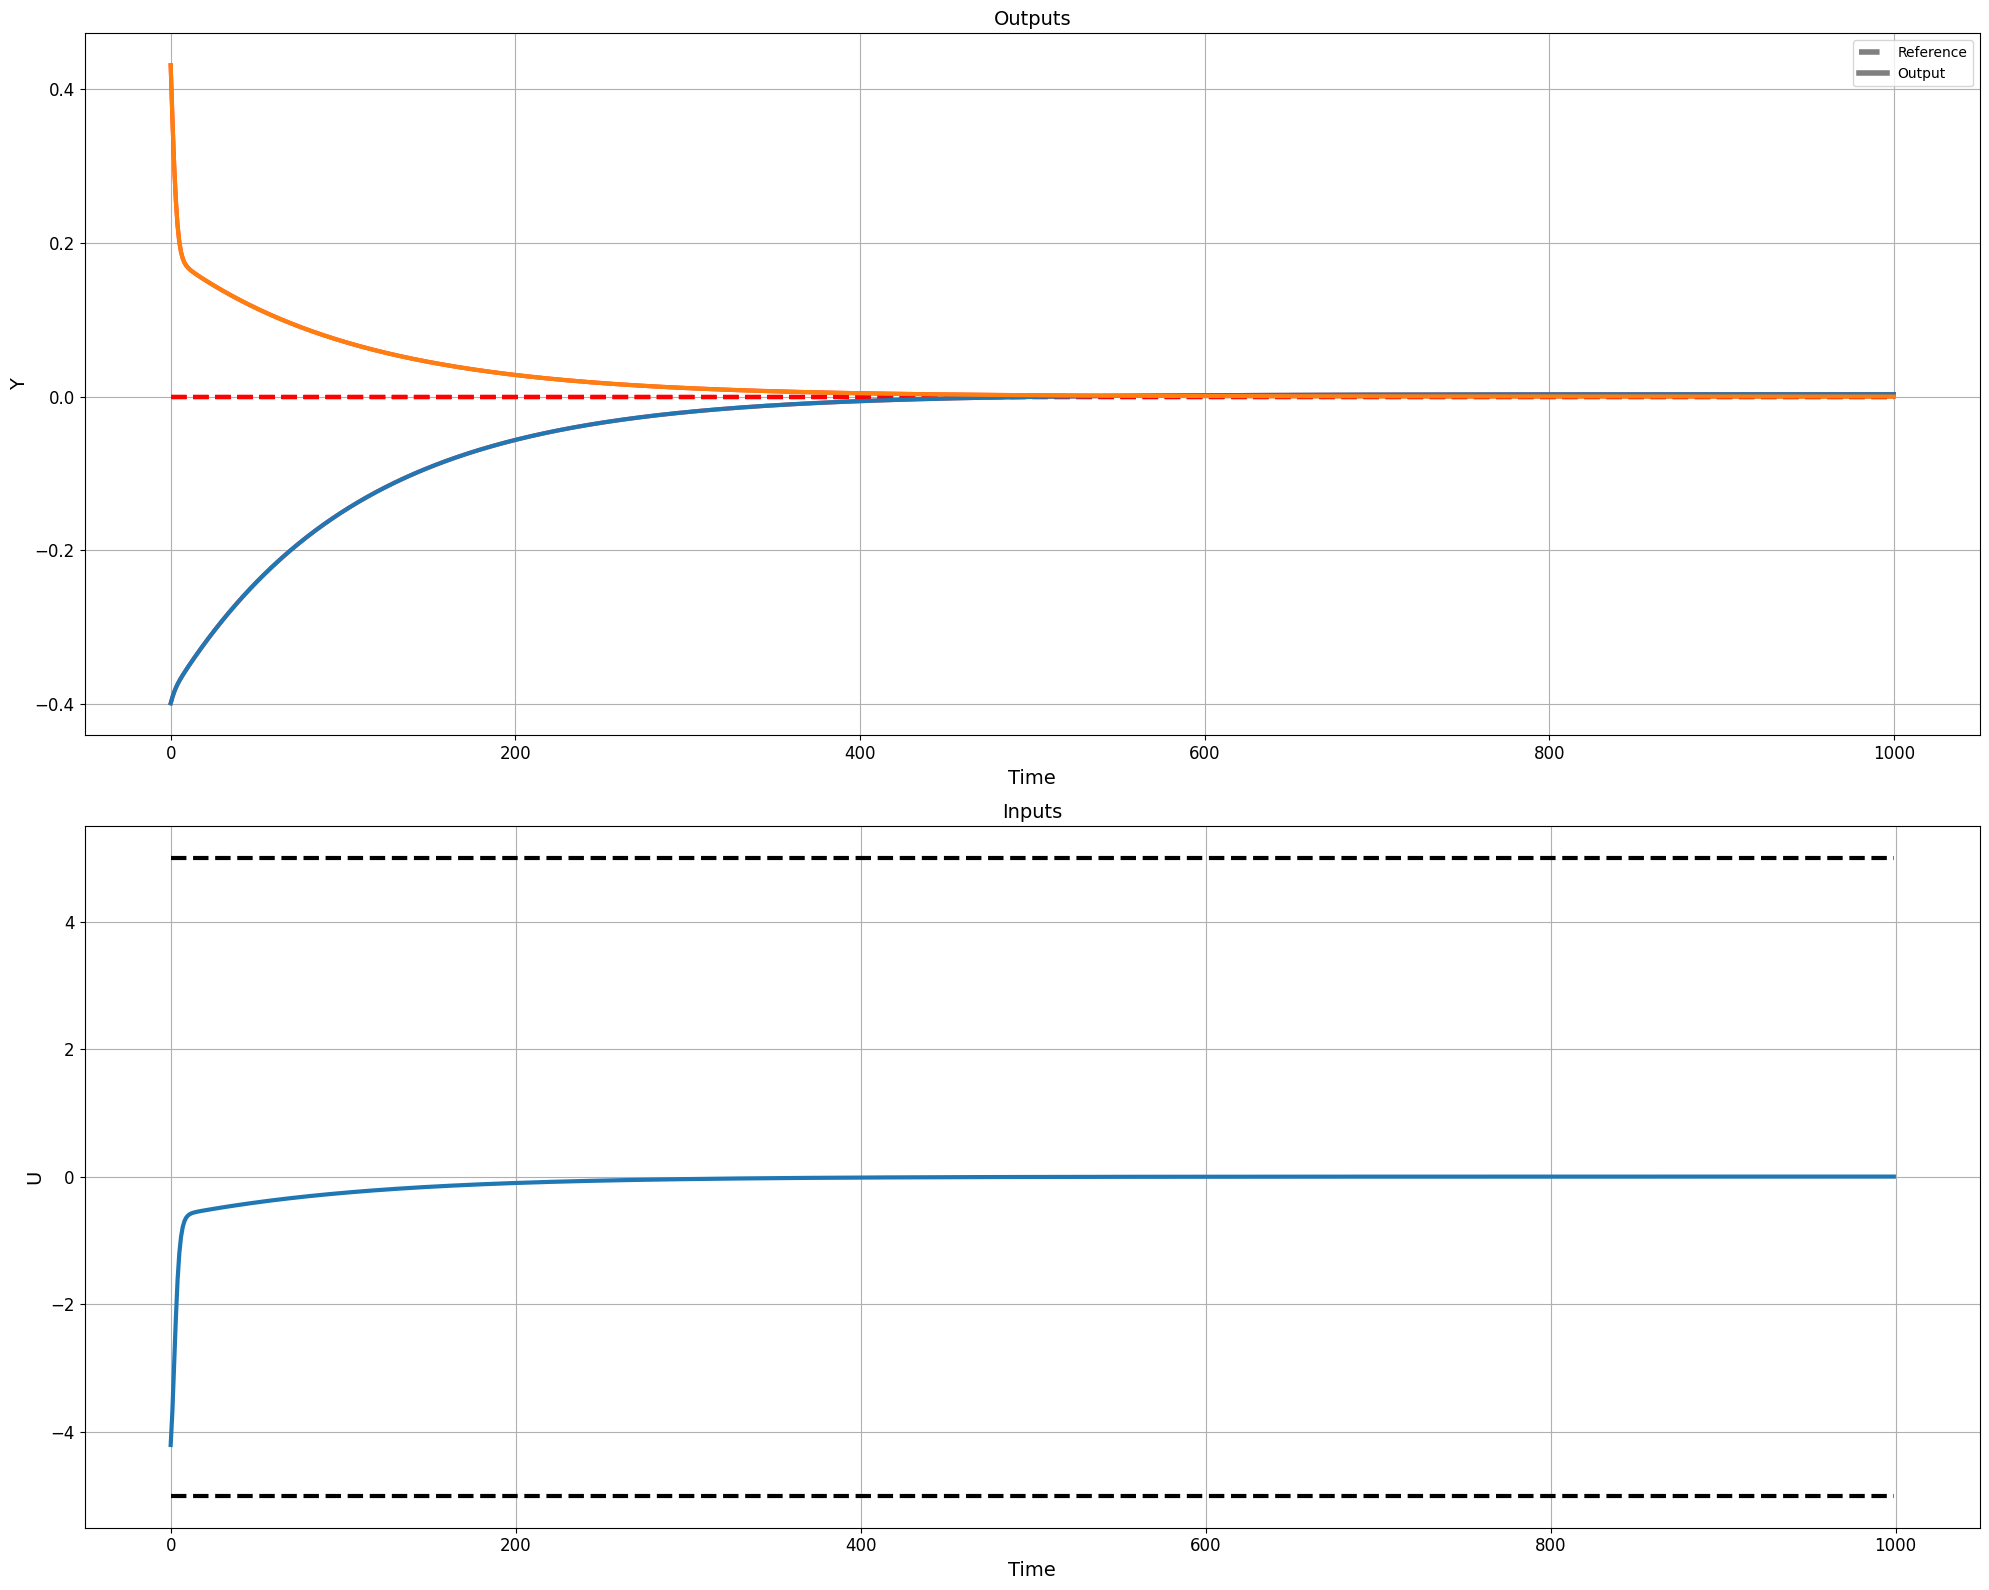

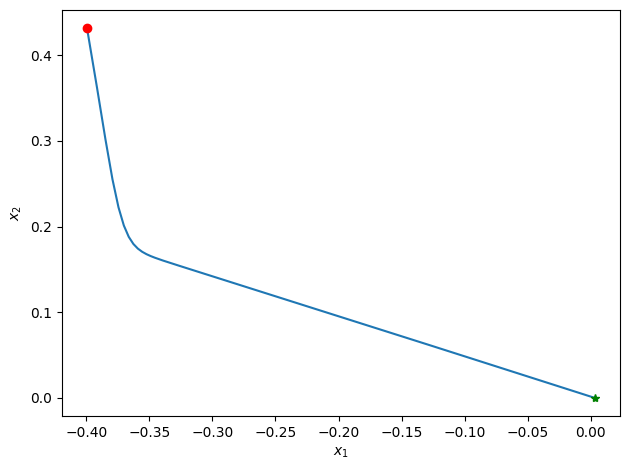

<Figure size 640x480 with 0 Axes>

In [8]:
print('\nTest Closed Loop System \n')
nsteps = 1000
# generate initial data for closed loop simulation
data = {'x': torch.randn(1, 1, nx, dtype=torch.float32),
        'r': torch.zeros(1, nsteps+1, nx, dtype=torch.float32)}
cl_system.nsteps = nsteps
# perform closed-loop simulation
trajectories = cl_system(data)

# constraints bounds
Umin = umin * np.ones([nsteps, 1])
Umax = umax * np.ones([nsteps, 1])
Xmin = xmin * np.ones([nsteps+1, 1])
Xmax = xmax * np.ones([nsteps+1, 1])
# plot closed loop trajectories
pltCL(Y=trajectories['x'].detach().reshape(nsteps + 1, 2),
      R=trajectories['r'].detach().reshape(nsteps + 1, 2),
      U=trajectories['u'].detach().reshape(nsteps, 1),
      Umin=Umin, Umax=Umax,
      figname='cl.png')
# plot phase portrait
pltPhase(X=trajectories['x'].detach().reshape(nsteps + 1, 2),
         figname='phase.png')
